# Machine Learning LAB 1: MODEL SELECTION

Course 2024/25: *F. Chiariotti*

The notebook contains a simple learning task over which we will implement **MODEL SELECTION AND VALIDATION**.

Complete all the **required code sections** and **answer all the questions**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Polynomial Classification on Signal to Noise Ratios

In this notebook we are going to explore the use of polynomial classification with polynomial regression. We are going to use the Numpy **polyfit** function, which performs polynomial regression.

Our use case is a communication problem: we have a set of measurements of the Signal to Noise Ratio (SNR), i.e., the quality of the communication link, in various positions. The SNR depends on two components: firstly, the noise level (which is a random variable that does not depend on position) and the signal attenuation (usually modeled as a polynomial function of the distance).

Our transmitter is in (0,0), and coordinates are in meters. In urban scenarios, the attenuation usually follows a third-degree polynomial, but it might be a fourth- or fifth-degree polynomial in more complex cases. How do we choose between different degrees? We will try with a maximum of **6**

---

## Import all the necessary Python libraries

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import itertools
from matplotlib import pyplot as plt

---

## Load the data

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [3]:
df = pd.read_csv('data/snr_measurements.csv',sep=';')
x = df['x'].to_numpy()
y = df['y'].to_numpy()
SNR = df['SNR'].to_numpy()

## Helper functions

These functions will help us evaluate the results

In [4]:
def compute_distance(x, y):
    # TODO: Compute the Euclidean distance from the origin
    distance = np.sqrt(x**2 + y**2)
    return distance

def fit(distance, SNR, degree):
    return np.polyfit(distance, SNR, deg=degree)

def predict(distance, poly_coeffs):
    # TODO: Predict the SNR from a given model
    """NOTICE: np.polyfit returns an array of length d+1 with higher powers first"""
    coeffs = poly_coeffs[::-1]
    SNR = 0
    for deg in range(len(poly_coeffs)): 
        SNR += coeffs[deg] * distance**deg
    return SNR 

def evaluate(distance, SNR, poly_coeffs):
    # TODO: Compute the error of the polynomial fit on the chosen data
    mse = 0
    for i in range(len(SNR)): 
        mse+=((predict(distance[i], poly_coeffs)) - SNR[i])**2
    mse/=len(SNR)
    return mse

def separate_test(distance, SNR, test_points):
    # TODO: Return a training set and a test set (the test_points parameter controls the number of test points)
    # The points should be selected randomly
    m = len(SNR)
    idx = np.random.choice(np.arange(m), size=m, replace=False, p=None) # I could also use np.random.permutation(m)
    train_idx = idx[:-test_points]
    test_idx = idx[-test_points:]
    x_train = distance[train_idx]
    y_train = SNR[train_idx]
    x_test = distance[test_idx]
    y_test = SNR[test_idx]
    return x_train, y_train, x_test, y_test

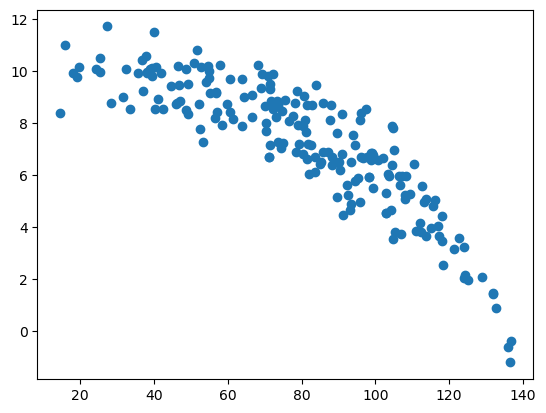

In [5]:
# TODO: separate the training and test sets and create a scatter plot of the SNR as a function of the distance
distance = compute_distance(x,y)
test_points = 40
x_train, y_train, x_test, y_test = separate_test(distance, SNR, test_points)

plt.scatter(distance, SNR)

## A. K-fold cross-validation

In this case, x and y are the two coordinates, and the SNR is the thing we are trying to predict

In [6]:
# Function to perform the K-fold cross validation
def k_fold_cross_validation(x_train: np.ndarray, y_train: np.ndarray, k: int, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: Perform K-fold cross-validation on the training set.
    # The two returned values are the best model and the list of results for all degrees up to max_degree.
    # The points should be selected randomly.
    # The inputs and labels are already in terms of distance and SNR. 

    # Create the folds
    x_folds = []
    y_folds = []
    m = len(x_train)
    idx = np.arange(m)
    fold_points = int(m/k)
    for fold in range(k): 
        fold_idx = np.random.choice(idx, fold_points, replace = False)
        idx = [i for i in idx if i not in fold_idx]
        x_folds.append(x_train[fold_idx])
        y_folds.append(y_train[fold_idx])

    # Now run validation
    best_perf = 1e20
    results = []
    for degree in range(max_degree + 1):
        deg_perf = 0
        for i in range(k): 
            val_x = x_folds[i]
            val_y = y_folds[i]
            train_x = np.concatenate([x for j,x in enumerate(x_folds) if j!=i])
            train_y = np.concatenate([y for j,y in enumerate(y_folds) if j!=i])
            poly_coeffs_k_deg = fit(train_x, train_y, degree)
            val_k_deg = evaluate(val_x, val_y, poly_coeffs_k_deg)
            deg_perf += val_k_deg/k
        results.append(deg_perf)
        if deg_perf < best_perf:
            best_perf = deg_perf
            best = fit(x_train, y_train, degree)
            
    return best, results

Best degree 4


Text(0.5, 1.0, 'Average MSE over validation for each degree')

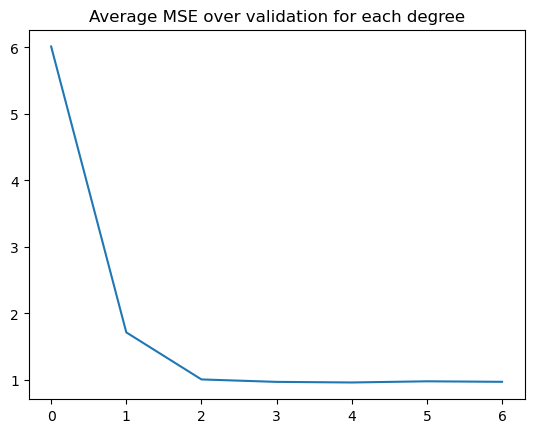

In [7]:
# TODO: run the training with K-fold cross-validation with 40 test points and 4 folds. 
#Plot the validation score as a function of the degree

distance = compute_distance(x,y)
test_points = 40

x_train, y_train, x_test, y_test = separate_test(distance, SNR, test_points)

k = 4
max_degree = 6
best_KFC, results_KFC = k_fold_cross_validation(x_train, y_train, k, max_degree)

print("Best degree", len(best_KFC)-1)
plt.plot(range(max_degree + 1), results_KFC)
plt.title("Average MSE over validation for each degree")

Test KFC value: 0.9531686518209153


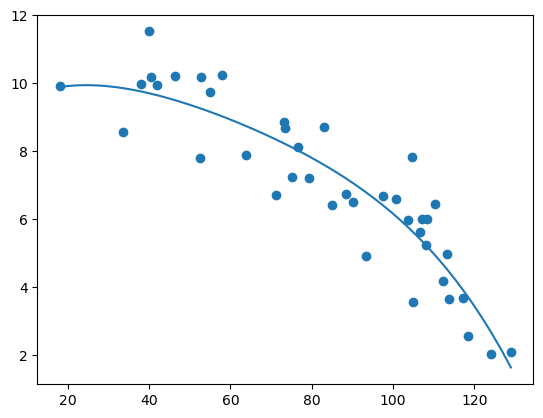

In [8]:
# TODO: get the test performance of the best model and plot the model output and test points. 
test_KFC = evaluate(x_test, y_test, best_KFC)

x_space = np.linspace(np.min(x_test), np.max(x_test))
plt.scatter(x_test, y_test)
plt.plot(x_space, predict(x_space, best_KFC))

print("Test KFC value:", test_KFC)

**COMMENT:**
> NOTICE:

Due to having a pretty small data set, it's easy for the model to get "a little confused" and fit on a little bit of noise even with cross validation.

> Try running the program multiple times, changing the values of K and the number of test points: is the output always the same?

* Changing the value of K
  
  - If we use a lower K (for example K = 2): we have larger variability on the results, because even tho we have a larger validation set per fold, we have less training points per fold (so more variable result) and the validation also then will oscillate quite a bit depending on how the split was made (so over folds) and is not averaged over many samples unfortunately, so at each full run of the program, the results can vary significantly due to the instability of the validation process. 
 
  - If we use a larger K (for example K = 6): we tend to stay closer to the actual degree the data was drawn from. This can be explained by the fact that, having more folds, the validation is more robust since it's averaged over more samples, so it's less sensitive to single splits. 
 
* Changing the value of test_points

  - If we use more test_points: we leave fewer training points for the model, which can lead to overfitting when the training set becomes too small, which might make the model overfit, leading to a higher estimated polynomial degree.

  - If we use less test_points: the training set becomes larger, allowing the model to generalize better. However, with fewer test points, the observed results can be more variable, since the evaluation set is smaller and less representative of the overall performance.

---

## B. Tikhonov regularization

Change the loss function to include a Tikhonov regularization term, as an alternative to cross-validation (try $\lambda=0.01$)

In [9]:
def evaluate_tikhonov(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: apply Tikhonov regularization AFTER the fitting process
    # Now run validation
    best_perf = 1e20
    results = []
    for degree in range(max_degree + 1): 
        poly_coeffs_deg = fit(x_train, y_train, degree) # This finds the best parameters for this degree over the training set
        deg_perf = evaluate(x_train, y_train, poly_coeffs_deg) # This evaluates the parameters choice over MSE
        deg_perf += lambda_par*np.dot(poly_coeffs_deg,poly_coeffs_deg) # Now we check the performance with regularization lambda*(w)^2
        results.append(deg_perf)
        if deg_perf < best_perf:
            best_perf = deg_perf
            best = poly_coeffs_deg
    return best, results

Best degree 6


Text(0.5, 1.0, 'MSE with Tikhonov over validation for each degree')

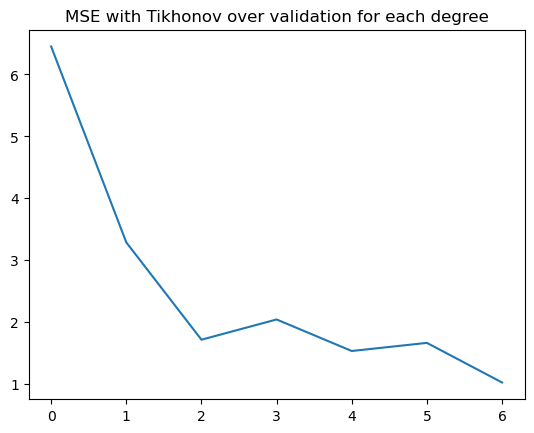

In [10]:
# TODO: run the training with Tikhonov regularization and plot the loss as a function of the degree
distance = compute_distance(x,y)
test_points = 40

x_train, y_train, x_test, y_test = separate_test(distance, SNR, test_points)

max_degree = 6
lambda_par = 0.01

best_Tik, results_Tik = evaluate_tikhonov(x_train, y_train, lambda_par, max_degree)

print("Best degree", len(best_Tik)-1)
plt.plot(range(max_degree + 1), results_Tik)
plt.title("MSE with Tikhonov over validation for each degree")

## C. Minimum description length regularization

Change the loss function to include a representation length regularization term, as an alternative to cross-validation. The minimum description length of a polynomial of degree N is O(2^N) - try $\lambda=0.02$

In [11]:
def evaluate_representation(x_train: np.ndarray, y_train: np.ndarray, lambda_par: float, max_degree: int) -> tuple[tuple, tuple]:
    # TODO: apply Tikhonov regularization AFTER the fitting process
    best_perf = 1e20
    results = []
    for degree in range(max_degree + 1): 
        poly_coeffs_deg = fit(x_train, y_train, degree) # This finds the best parameters for this degree over the training set
        deg_perf = evaluate(x_train, y_train, poly_coeffs_deg) # This evaluates the parameters choice over MSE
        deg_perf += lambda_par*2**degree # Now we check the performance with MDL
        results.append(deg_perf)
        if deg_perf < best_perf:
            best_perf = deg_perf
            best = poly_coeffs_deg
    return best, results

best_degree 2


Text(0.5, 1.0, 'MSE with MDL over validation for each degree')

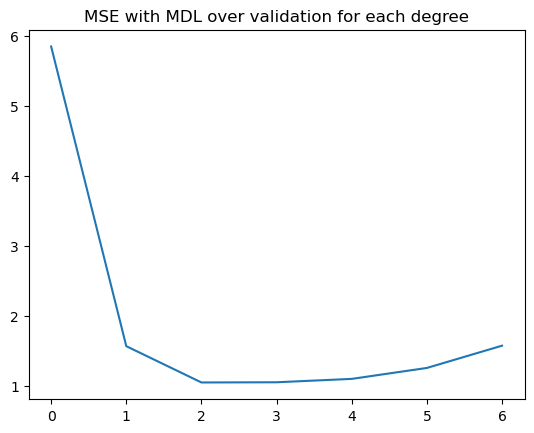

In [12]:
# TODO: run the training with MDL regularization and plot the loss as a function of the degree
distance = compute_distance(x,y)
test_points = 40

x_train, y_train, x_test, y_test = separate_test(distance, SNR, test_points)

max_degree = 6
lambda_par = 0.01

best_MDL, results_MDL = evaluate_representation(x_train, y_train, lambda_par, max_degree)

print("best_degree", len(best_MDL)-1)
plt.plot(range(max_degree + 1), results_MDL)
plt.title("MSE with MDL over validation for each degree")

### TEST

Check the performance of the three solutions on the test set: which one does best?


Test KFC value: 0.7777583012457294
Test Tikhonov value: 0.7719243605995796
Test MDL value: 0.7747887527069025


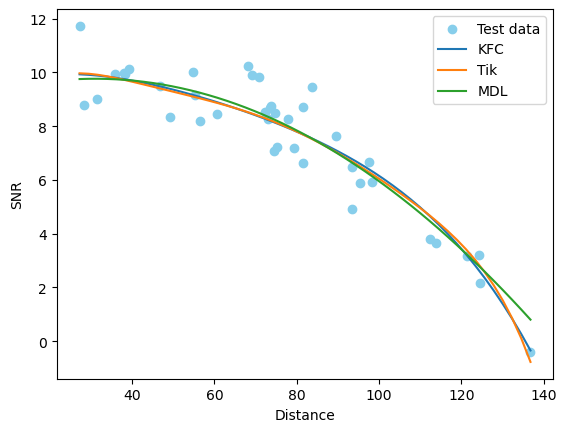

In [13]:
# TODO: plot the results
x_space = np.linspace(np.min(x_test), np.max(x_test))

test_KFC = evaluate(x_test, y_test, best_KFC)
test_Tik = evaluate(x_test, y_test, best_Tik)  
test_MDL = evaluate(x_test, y_test, best_MDL) 

plt.scatter(x_test, y_test, label = 'Test data', color = 'skyblue')
plt.plot(x_space, predict(x_space, best_KFC), label = 'KFC')
plt.plot(x_space, predict(x_space, best_Tik), label = 'Tik')
plt.plot(x_space, predict(x_space, best_MDL), label = 'MDL')
plt.xlabel('Distance')
plt.ylabel('SNR')
plt.legend()

print("Test KFC value:", test_KFC)
print("Test Tikhonov value:", test_Tik)
print("Test MDL value:", test_MDL)

**COMMENT**:
> NOTICE:

For comparison between the three different methods, we use MSE on test set. Indeed, if we used different loss functions for different methods, we wouldn't have a meaningful comparison since we'd be measuring performance differently from each.

Regularized loss functions (like Tikhonov regularized loss or MDL) are used during **model selection** to **avoid overfitting**. 
Once you've selected the optimal model, you should evaluate it on test data using a standard loss (as MSE) to see how well it generalizes. 

> which one does best?

From what we can see above, the result is pretty similar for the three, even though MDL appears to do a little worse. 
